# **Environment Set-Up**

Before anything, we need to import some Python packages to help with data inspection and visualization: 

- **matplotlib** - Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

- **math** -  It provides access to the mathematical functions defined by the C standard.

- **pandas** - Open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **scipy** - A Python-based ecosystem of open-source software for mathematics, science, and engineering.

- **scikit-learn** - Machine learning in Python

- **warnings** - Used for formatting the Jupyter Notebook

# **Data Preview**

Let's import the aforementioned packages:

In [10]:
import warnings
from math import sqrt, pow

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import wiener
from sklearn import (tree,
                     metrics)
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split  

warnings.simplefilter("ignore")

Previewing the data, we have five features - time elapsed from the start of the recording (in seconds), accelerometry data in the xyz directions, and a classification label called "fall" which has values of either 0 - indicating no fall - or 1 which indicates a fall.

In [2]:
test_data = pd.read_csv("Data/labeled_data.csv")

test_data.head(5)

,elapsed (s),x-axis (g),y-axis (g),z-axis (g),fall
0,0.00,0.395,-0.893,-0.107,0
1,0.08,0.354,-0.969,-0.139,0
2,0.16,0.361,-0.966,-0.125,0
3,0.24,0.359,-0.987,-0.146,0
4,0.32,0.300,-0.942,-0.126,0


The following method builds upon the signal processing method developed in last phase to smooth out our signal. Here, we are invoking the wiener filter over a smoothed signal which was smoothed via a 3 point rolling average. 

Now, we can slice up the data and preview the data.

In [3]:
x_acc = test_data["x-axis (g)"]
y_acc = test_data["y-axis (g)"]
z_acc = test_data["z-axis (g)"]

time = test_data["elapsed (s)"]
fall = test_data["fall"]

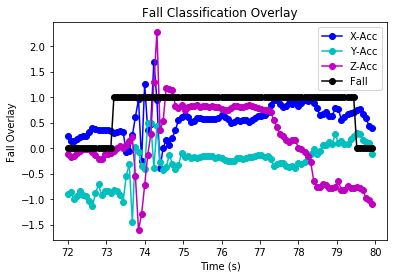

In [22]:
plt.plot(time[900:1000], x_acc[900:1000], "bo-", label="X-Acc")
plt.plot(time[900:1000], y_acc[900:1000], "co-", label="Y-Acc")
plt.plot(time[900:1000], z_acc[900:1000], "mo-", label="Z-Acc")
plt.plot(time[900:1000], fall[900:1000], "ko-", label="Fall")

plt.title("Fall Classification Overlay")
plt.ylabel("Fall Overlay")
plt.xlabel("Time (s)")
plt.legend()

plt.show()

Now let's apply the 3 Point Rolling Average Filter in conjunction with a Wiener Filter. 

In [4]:
rolling_avg_val = 3
padded_list = rolling_avg_val * [[0]]

smoothed_x = pd.concat([pd.DataFrame(padded_list), test_data["x-axis (g)"]],
                        ignore_index=True)
smoothed_y = pd.concat([pd.DataFrame(padded_list), test_data["y-axis (g)"]],
                        ignore_index=True)
smoothed_z = pd.concat([pd.DataFrame(padded_list), test_data["z-axis (g)"]],
                        ignore_index=True)

smoothed_x = test_data["x-axis (g)"].rolling(rolling_avg_val).mean()
smoothed_y = test_data["y-axis (g)"].rolling(rolling_avg_val).mean()
smoothed_z = test_data["z-axis (g)"].rolling(rolling_avg_val).mean()

smoothed_x = smoothed_x.fillna(0)
smoothed_y = smoothed_y.fillna(0)
smoothed_z = smoothed_z.fillna(0)

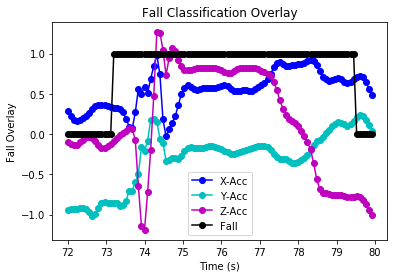

In [5]:
plt.plot(time[900:1000], wiener(smoothed_x)[900:1000], "bo-", label="X-Acc")
plt.plot(time[900:1000], wiener(smoothed_y)[900:1000], "co-", label="Y-Acc")
plt.plot(time[900:1000], wiener(smoothed_z)[900:1000], "mo-", label="Z-Acc")
plt.plot(time[900:1000], fall[900:1000], "ko-", label="Fall")

plt.title("Fall Classification Overlay")
plt.ylabel("Fall Overlay")
plt.xlabel("Time (s)")
plt.legend()

plt.show()

Taking an arbitrary fall from the data set, it looks like, from the outset, that the hand annotations worked out pretty well. Still, let's continue on to a correlational analysis to ensure that we are on track to use this data set for training.

# __Training Our Models__

This post relies heavily on the work from Luke Singham (https://lukesingham.com/whos-going-to-leave-next/) and advice from Lahiru Wimalasena

Starting with our raw data, let's do an 80/20 split of our data with 80% being training and 20% testing data. :

In [6]:
dataset = test_data.drop(["elapsed (s)", "fall"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(dataset, fall, test_size=0.2, random_state=0)

In [19]:
# Linear Regression Model

logit_model = LogisticRegression()  
logit_model = logit_model.fit(x_train, y_train)  
logit_model.score(x_train, y_train)  

predicted = pd.DataFrame(logit_model.predict(x_test))  
probs = pd.DataFrame(logit_model.predict_proba(x_test))  
print("Accuracy: {}".format(metrics.accuracy_score(y_test, predicted)))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.8155650319829424
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1532
           1       0.33      0.01      0.01       344

   micro avg       0.82      0.82      0.82      1876
   macro avg       0.58      0.50      0.45      1876
weighted avg       0.73      0.82      0.74      1876



In [20]:
# Decision Tree Model

tree_model = tree.DecisionTreeClassifier(max_depth=3)  
# Fit a decision tree
tree_model = tree_model.fit(x_train, y_train)  
# Training accuracy
tree_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(tree_model.predict(x_test))  
probs = pd.DataFrame(tree_model.predict_proba(x_test))

# Store metrics
tree_accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, predicted)))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.8246268656716418
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1532
           1       0.89      0.05      0.09       344

   micro avg       0.82      0.82      0.82      1876
   macro avg       0.86      0.52      0.50      1876
weighted avg       0.84      0.82      0.75      1876



In [21]:
# KNN Model

# instantiate learning model (k = 3)
knn_model = KNeighborsClassifier(n_neighbors=3)  
# fit the model
knn_model.fit(x_train, y_train)  
# Accuracy
knn_model.score(x_train, y_train)

# Predictions/probs on the test dataset
predicted = pd.DataFrame(knn_model.predict(x_test))  
probs = pd.DataFrame(knn_model.predict_proba(x_test))

# Store metrics
knn_accuracy = metrics.accuracy_score(y_test, predicted)  

print("Accuracy: {}".format(metrics.accuracy_score(y_test, predicted)))
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.8001066098081023
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1532
           1       0.43      0.30      0.35       344

   micro avg       0.80      0.80      0.80      1876
   macro avg       0.64      0.61      0.62      1876
weighted avg       0.78      0.80      0.79      1876

